<a href="https://colab.research.google.com/github/daemonX10/Generative-Deep-Learning/blob/main/01_Auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers ,models,datasets,callbacks
import tensorflow.keras.backend as K

In [ ]:
IMAGE_SIZE=32
CHANNELS =1
BATCH_SIZE=100
BUFFER_SIZE = 1000
VALIDATION_SPLIT=0.2
EMBEDDING_DIM =2
EPOCHS =3


In [ ]:

# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [ ]:

def preprocess(imgs):
    imgs =imgs.astype("float32")/255.0
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

x_train =preprocess(x_train)
x_test= preprocess(x_test)

In [ ]:
display(x_train)

In [ ]:
encoder_input =layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name='encoder_input')

x =layers.Conv2D(32,(3,3),strides=2,activation='relu',padding='same')(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2D(128,(3,3),strides=2,activation='relu',padding='same')(x)
shape_before_flattening=K.int_shape(x)[1:]

x=layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM,name='encoder_output')(x)

encoder = models.Model(encoder_input,encoder_output)
encoder.summary()

In [ ]:
decoder_input = layers.Input(shape=(2,),name='decoder_input')
x=layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x=layers.Reshape(shape_before_flattening)(x)
x=layers.Conv2DTranspose(128,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2DTranspose(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(x)

decoder_output=layers.Conv2D(1,(3,3),strides=1,activation='sigmoid',padding='same',name='decoder_output')(x)

decoder = models.Model(decoder_input,decoder_output)

In [ ]:
decoder.summary()

In [ ]:
autoencoder = models.Model(encoder_input,decoder(encoder_output))

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./kaggle/checkpoint.keras',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0,
)

tensorboard_callback =callbacks.TensorBoard(log_dir='./kaggle/loss.keras')

In [ ]:
autoencoder.fit(
  x_train,
  x_train,
  epochs=EPOCHS,
  batch_size = BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test,x_test),
    callbacks=[model_checkpoint_callback,tensorboard_callback]
)

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs("./kaggle/models", exist_ok=True)


In [ ]:
# Save the final models
autoencoder.save("./kaggle/models/autoencoder.keras")  # Use .keras extension
encoder.save("./kaggle/models/encoder.keras")
decoder.save("./kaggle/models/decoder.keras")

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
predications = autoencoder.predict(example_images)
print("example real clothing items")
display(example_images)
print('reconstruction')
display(predications)

In [ ]:
embeddings = encoder.predict(example_images)

In [ ]:
print(embeddings[:10])


In [ ]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [ ]:

# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [ ]:
mins , maxs = np.min(embeddings,axis=0),np.max(embeddings,axis=0)
grid_width ,grid_height = (6,3)
sample = np.random.uniform(mins,maxs,size=(grid_width*grid_height,EMBEDDING_DIM))

In [ ]:
reconstructions =decoder.predict(sample)

In [ ]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Pytorch

In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=tensor_transform
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5594581.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 147907.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1400817.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2264954.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
loader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size = 32,
    shuffle=True
)

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,36),
            torch.nn.ReLU(),
            torch.nn.Linear(36,18),
            torch.nn.ReLU(),
            torch.nn.Linear(18,9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9,18),
            torch.nn.ReLU(),
            torch.nn.Linear(18,36),
            torch.nn.ReLU(),
            torch.nn.Linear(36,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,28*28),
            torch.nn.Sigmoid()
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AE()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-1,weight_decay=1e-8)

AttributeError: 'list' object has no attribute 'detach'

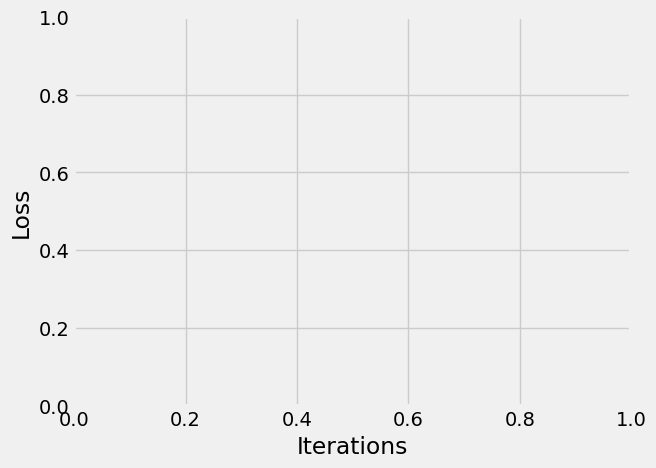

In [ ]:
epochs = 20
outputs=[]
losses =[]
for epoch in range(epochs):
    for (image,_) in loader:
        image = image.reshape(-1,28*28)
        reconstructed = model(image)
        loss = loss_function(reconstructed,image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    outputs.append((epochs,image,reconstructed))
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])

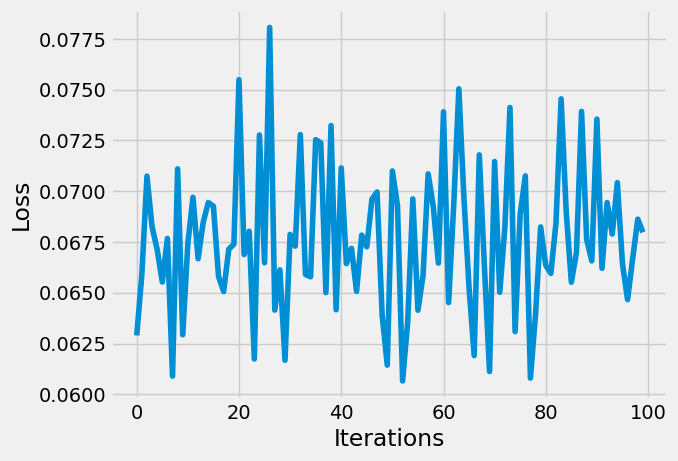

In [ ]:
# Detach all the tensors in the losses list and convert them to NumPy arrays
losses_numpy = [loss.detach().numpy() for loss in losses]

# Now you can plot the losses safely
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plot the last 100 detached loss values
plt.plot(losses_numpy[-100:])
plt.show()


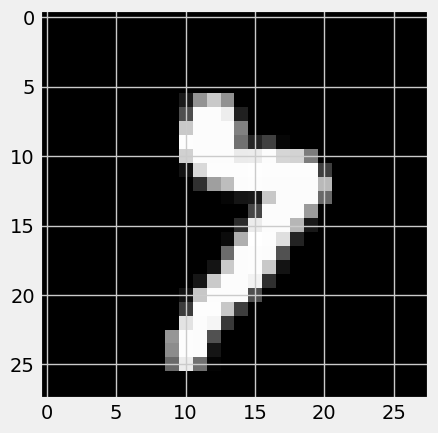

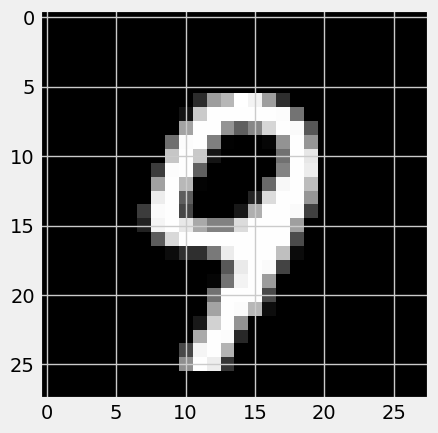

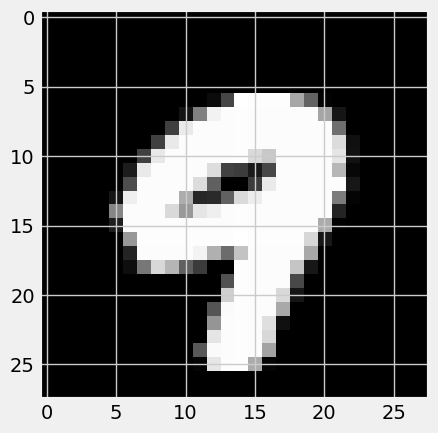

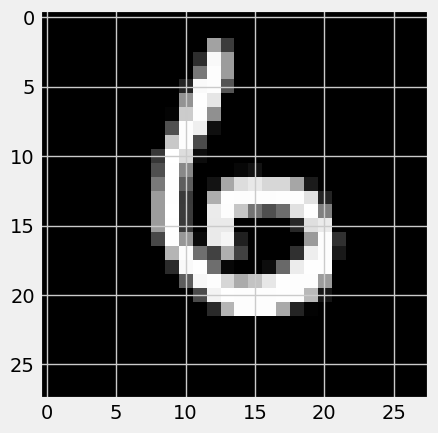

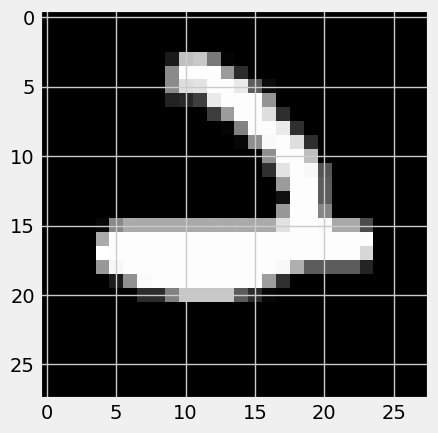

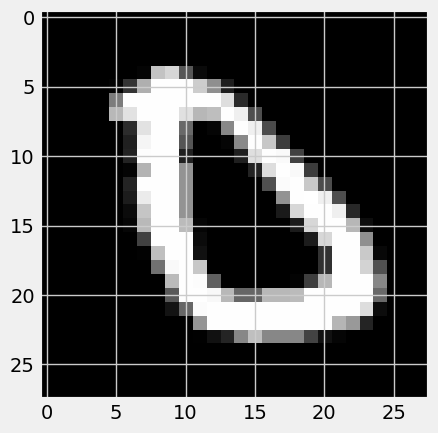

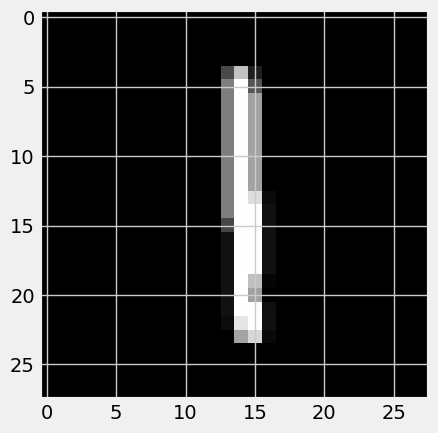

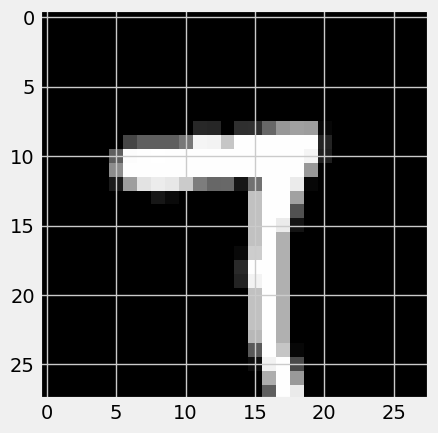

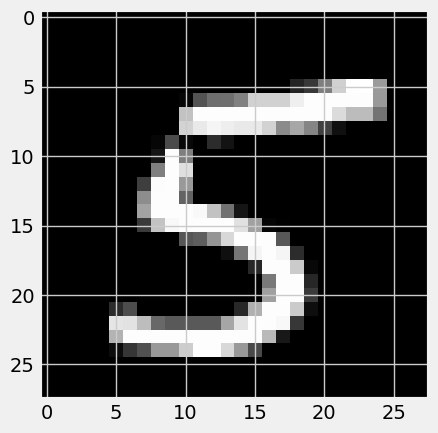

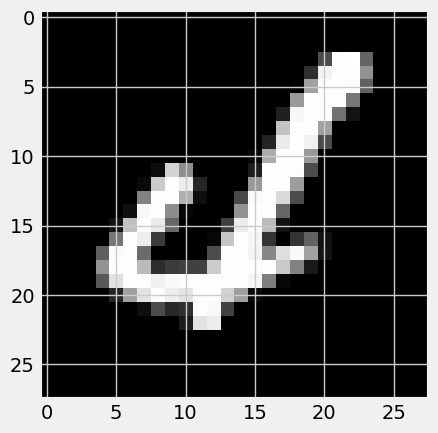

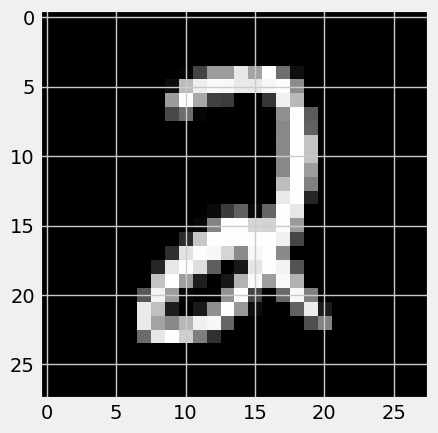

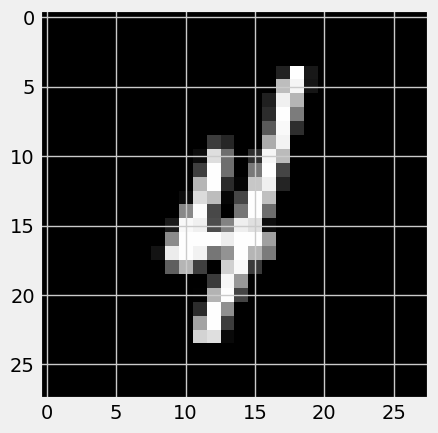

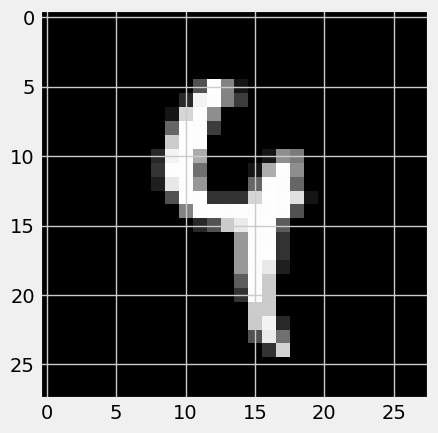

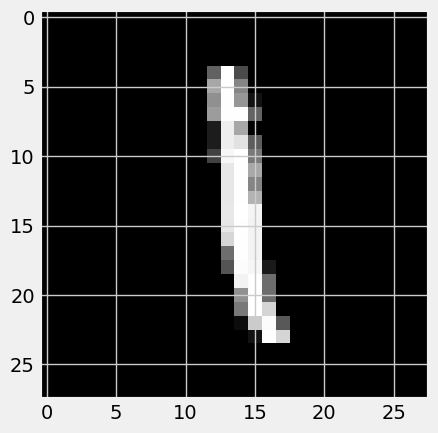

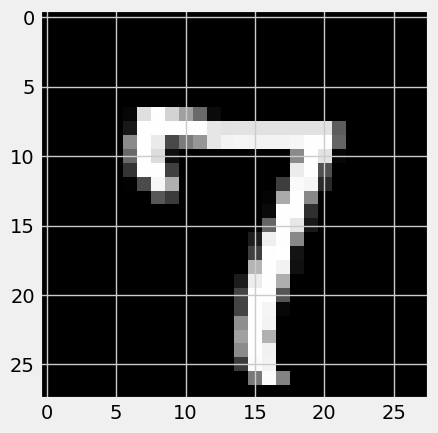

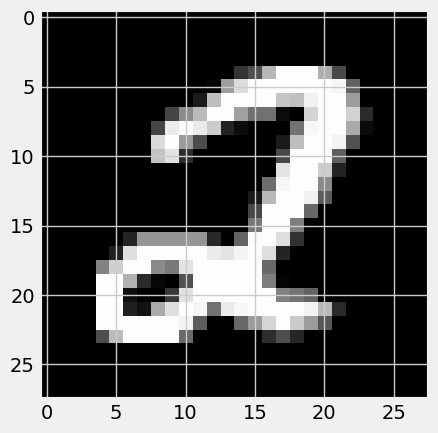

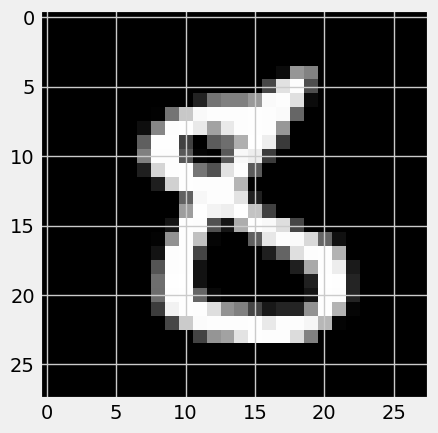

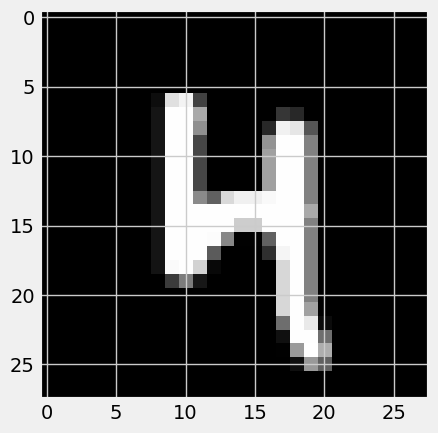

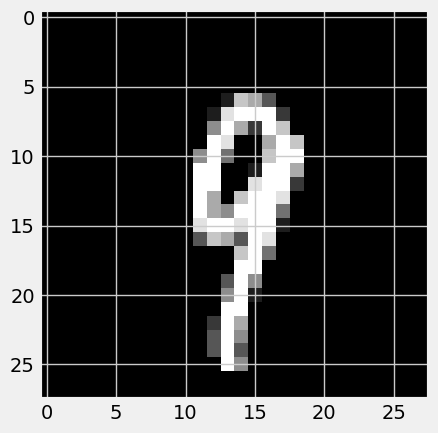

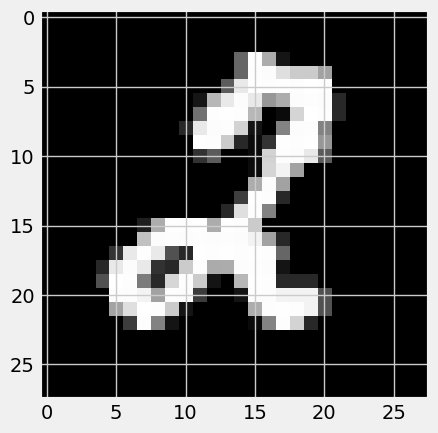

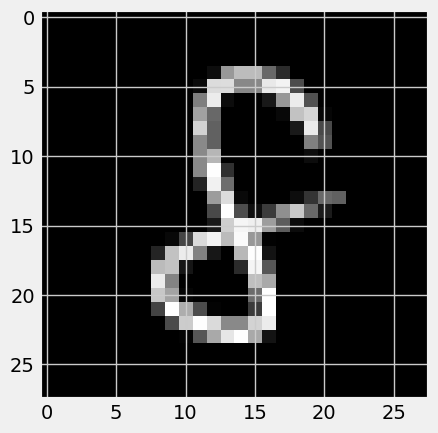

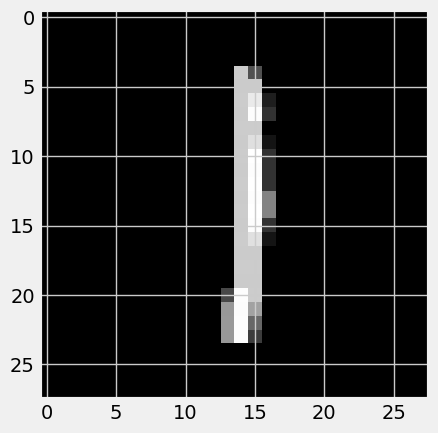

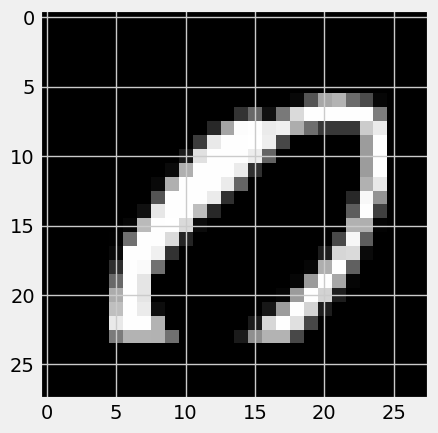

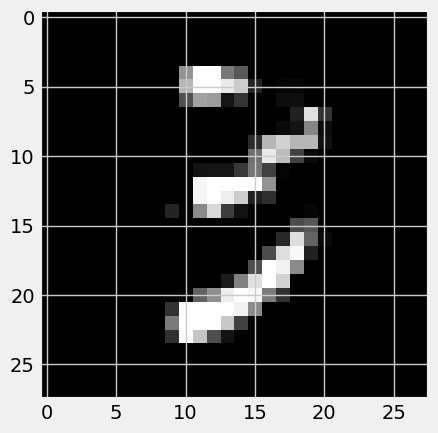

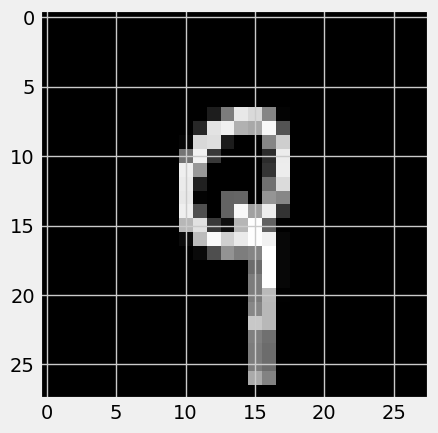

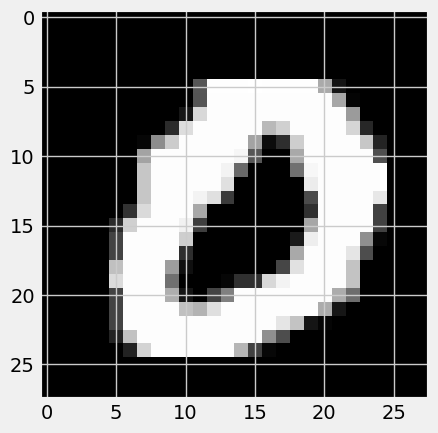

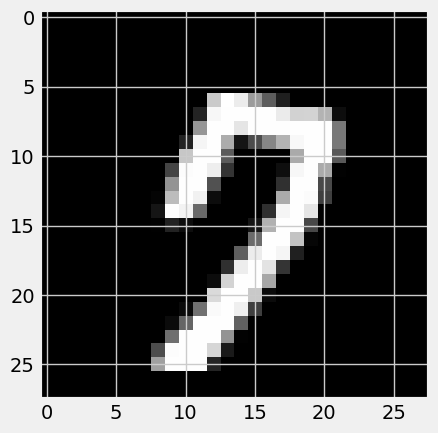

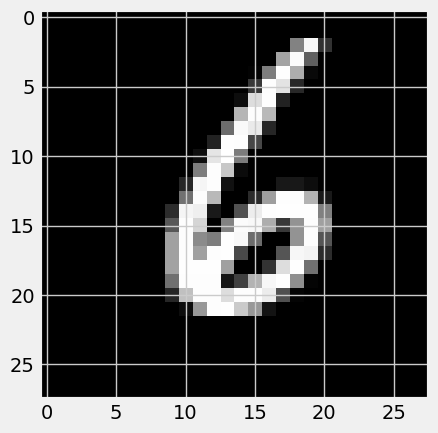

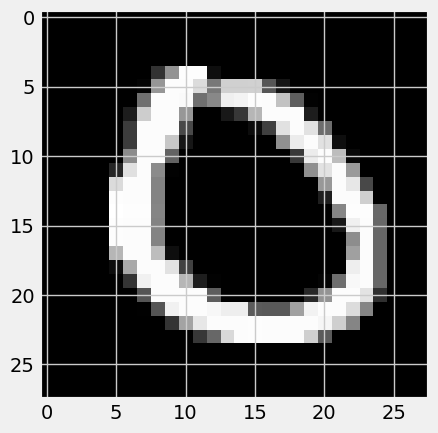

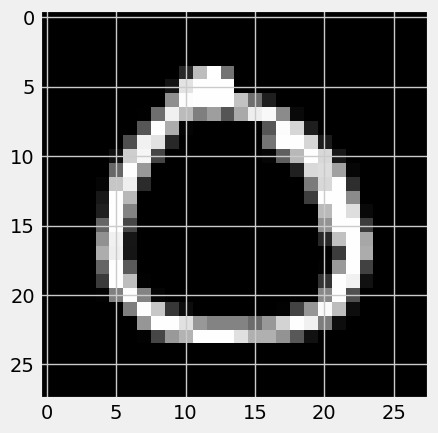

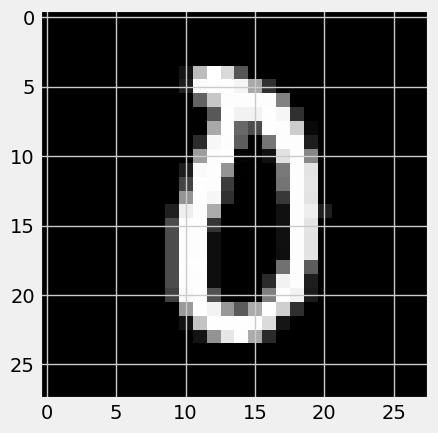

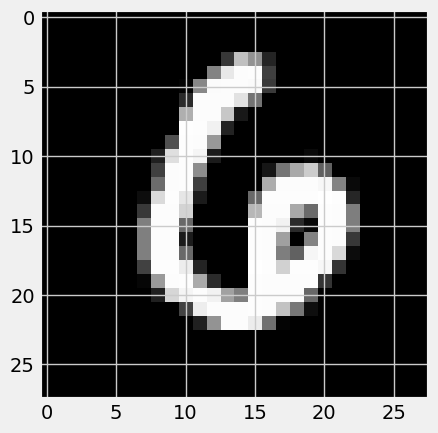

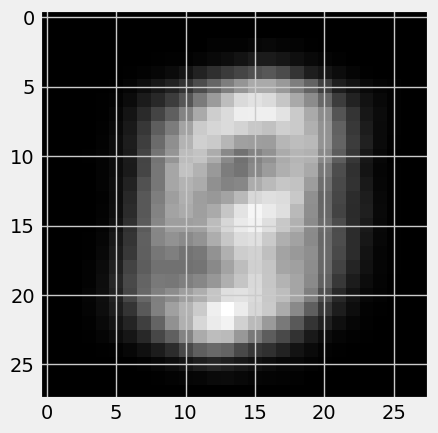

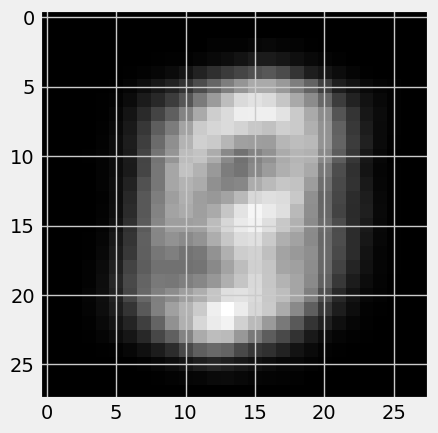

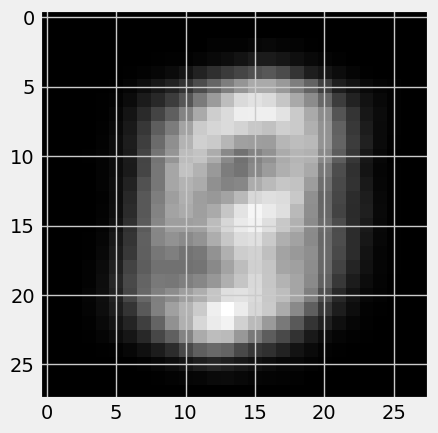

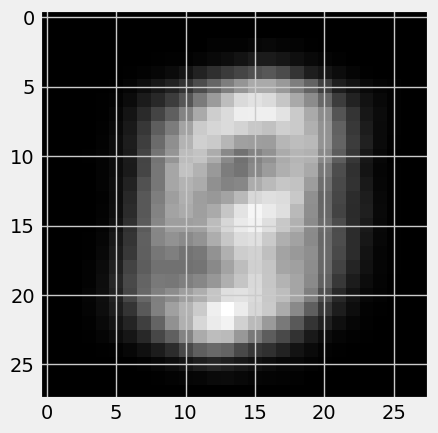

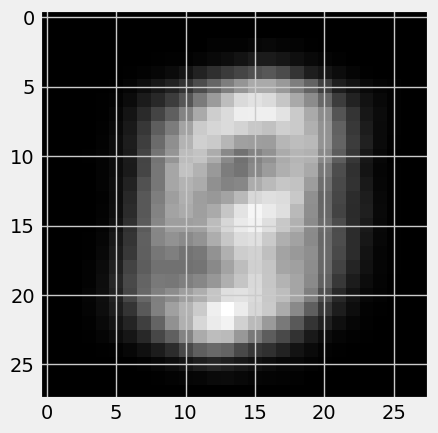

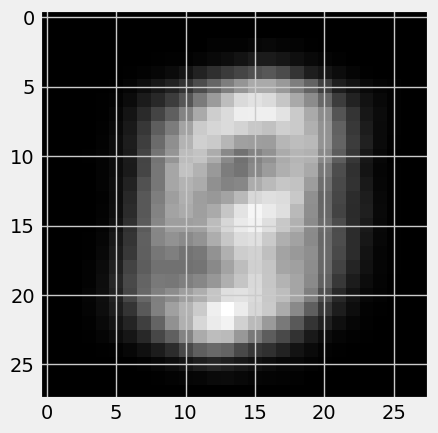

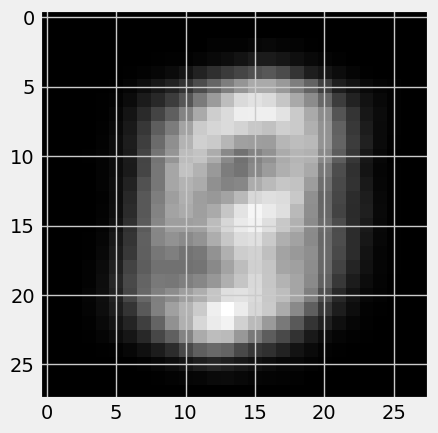

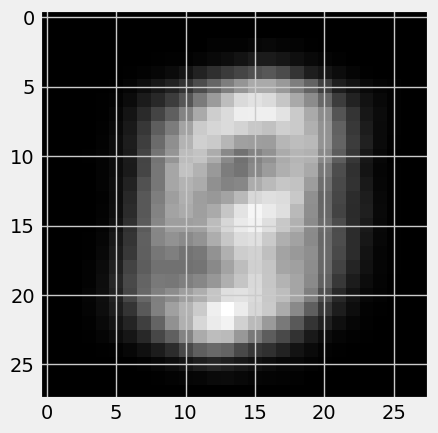

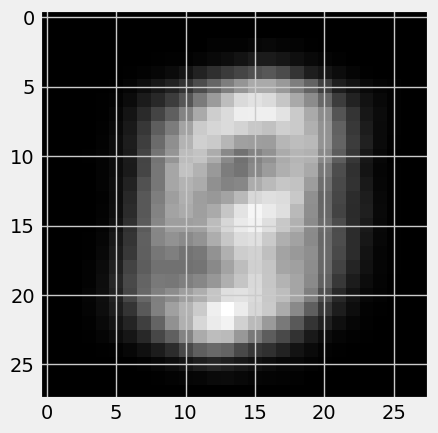

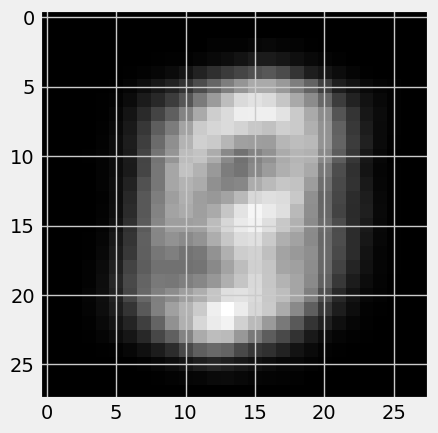

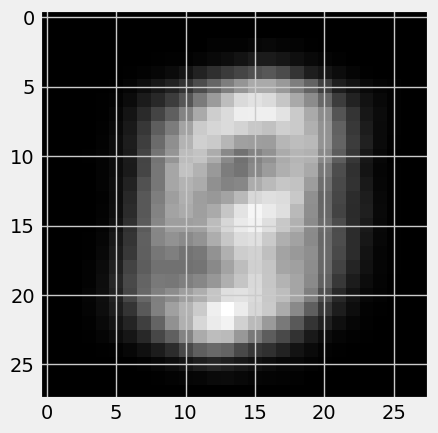

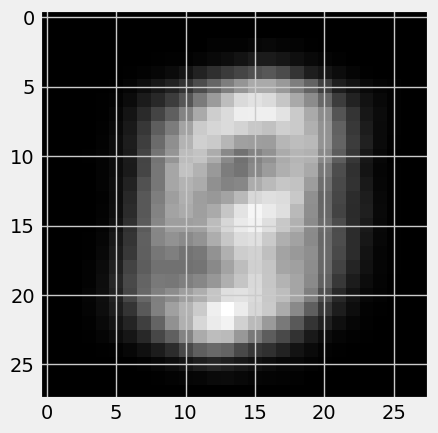

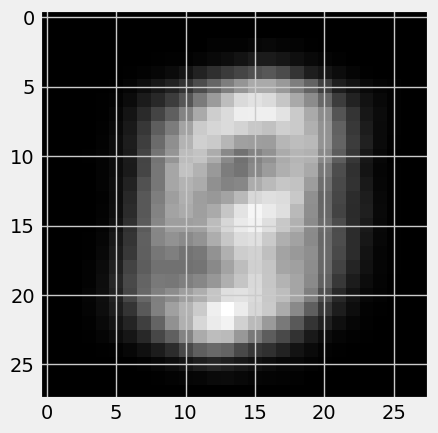

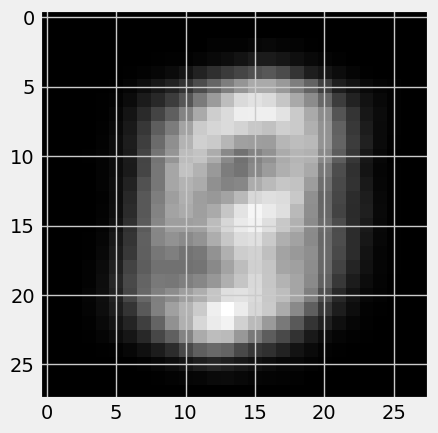

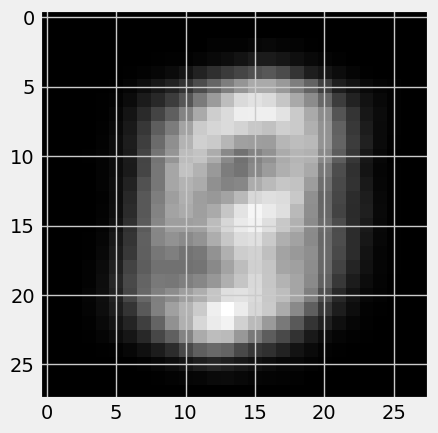

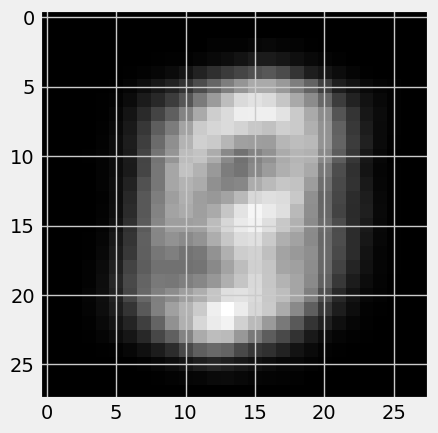

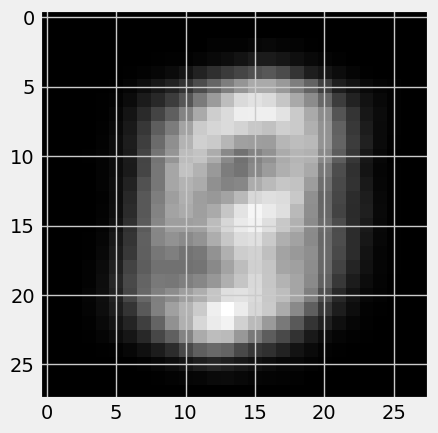

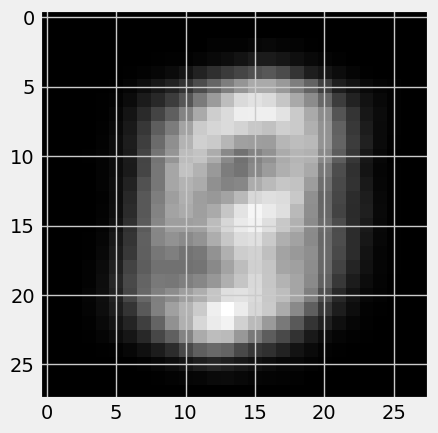

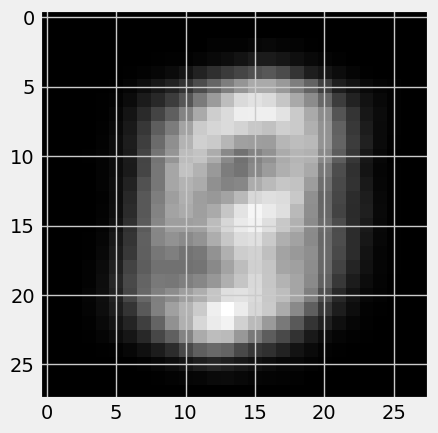

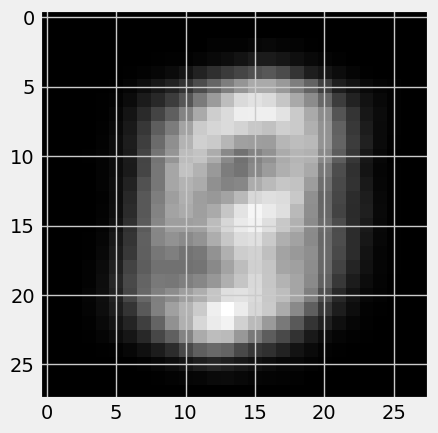

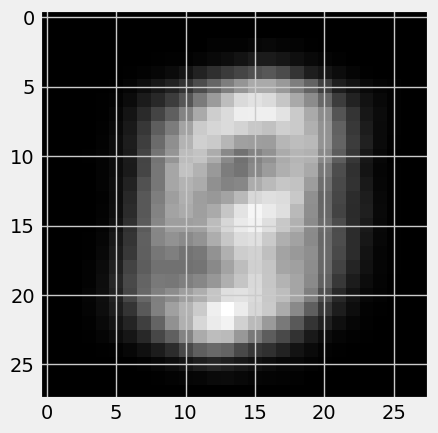

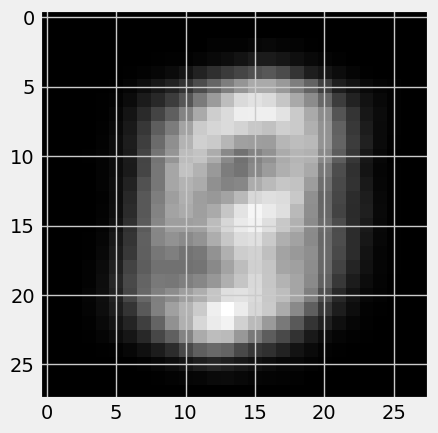

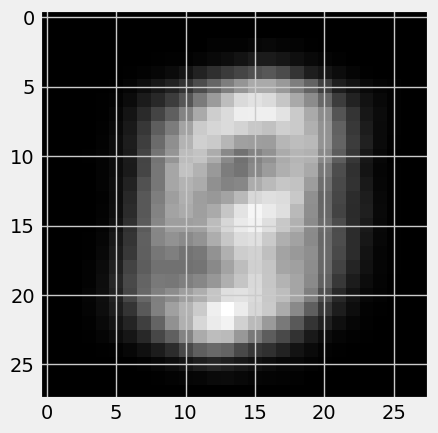

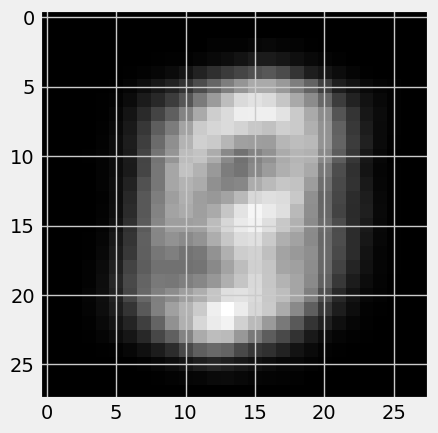

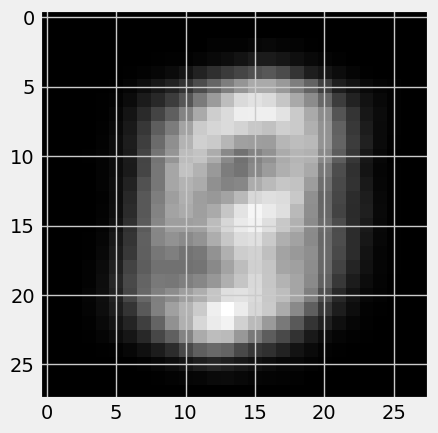

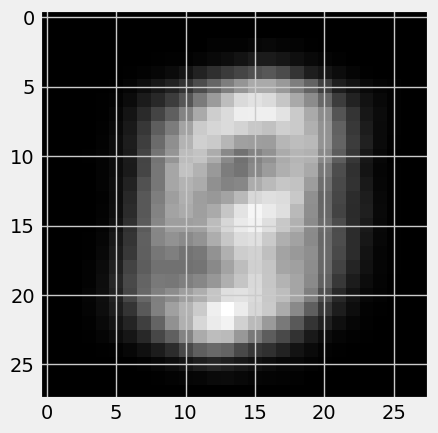

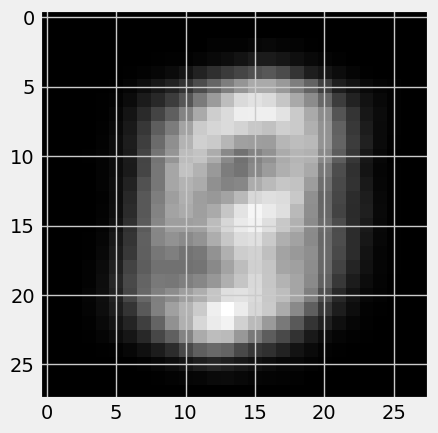

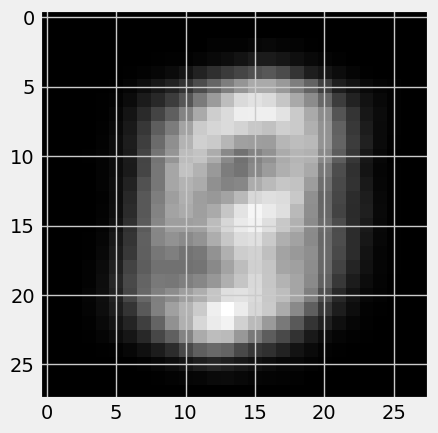

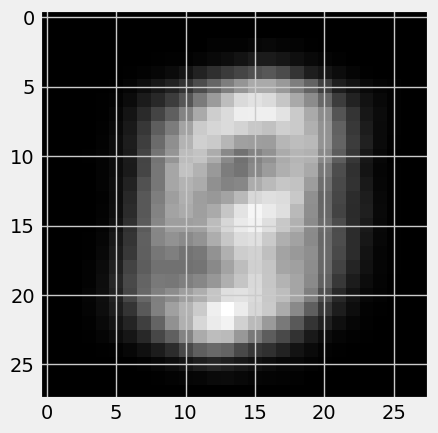

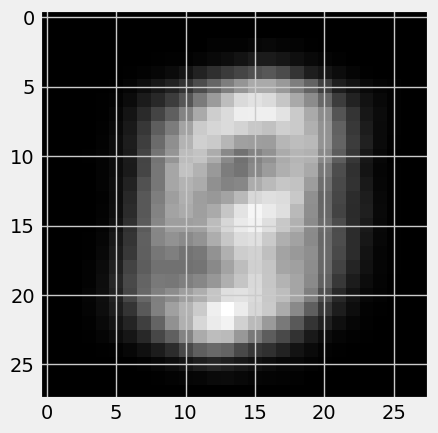

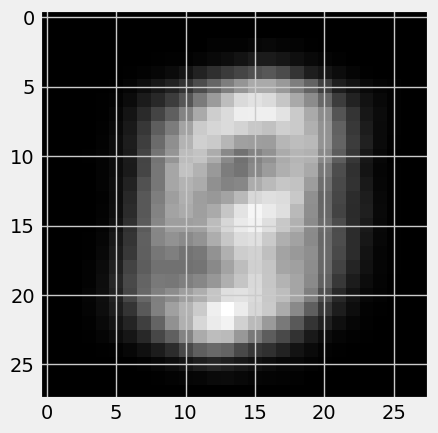

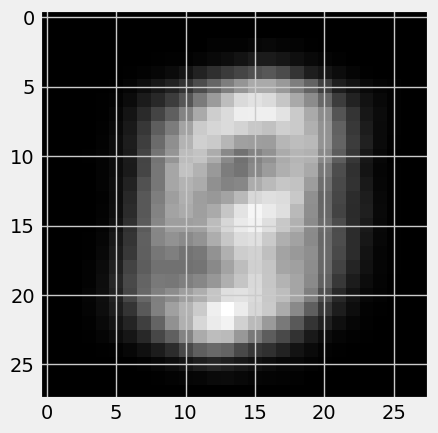

In [ ]:
for i, item in enumerate(image):
    item = item.reshape(-1, 28, 28)

    # Detach the tensor from the computation graph and convert to NumPy array
    plt.imshow(item[0].detach().numpy(), cmap='gray')
    plt.show()

for i, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)

    # Detach the tensor from the computation graph and convert to NumPy array
    plt.imshow(item[0].detach().numpy(), cmap='gray')
    plt.show()
